In [1]:
import keras_genomics
from keras_genomics.layers.convolutional import RevCompConv1D
import keras
import keras.layers as kl
from keras import backend as K 
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from seqdataloader.batchproducers import coordbased
from seqdataloader.batchproducers.coordbased import coordstovals
from seqdataloader.batchproducers.coordbased import coordbatchproducers
from seqdataloader.batchproducers.coordbased import coordbatchtransformers
from keras.models import load_model
from keras.utils import CustomObjectScope
import json
import gzip
import codecs
import os
from matplotlib import pyplot as plt
from scipy.stats import spearmanr, pearsonr, gaussian_kde
%matplotlib inline

Using TensorFlow backend.
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/amr1/mi

In [2]:
!head data/experimental/PBMArchive/Abf1_ungapped_8mers.txt

#ID_REF = 
#E-score = Enrichment score
#VALUE = Seed and wobble calculated normalized median signal intensity value
#Z-score = Z-score
ID_REF  E-score VALUE   Z-score
AAAAAAAA    0.03346 22564.33    0.9116
AAAAAAAC    0.07426 20463.07    0.0993
AAAAAAAG    0.06222 21404.07    0.4729
AAAAAAAT    0.17218 23745.28    1.3355
AAAAAACA    0.10956 23391.03    1.2106


In [3]:
seqToEScores = {}
seqToValues = {}
seqToZScores = {}
firstLine = True
with open("data/experimental/PBMArchive/Abf1_ungapped_8mers.txt") as inp:
    for line in inp:
        if line[0] == '#':
            continue
        if firstLine:
            firstLine = False
            continue
        Oligo,E,Val,Z = line.strip().split()
        seq = Oligo.upper()
        seqToEScores[seq] = float(E)
        seqToValues[seq] = float(Val)
        seqToZScores[seq] = float(Z)
        
seqs = []
evals = []
values = []
zvals = []
for curr_seq in seqToEScores.keys():
    seqs.append(curr_seq)
    evals.append(seqToEScores[curr_seq])
    values.append(seqToValues[curr_seq])
    zvals.append(seqToZScores[curr_seq])

In [4]:
keyToFiles = {}
keyToFiles["abf1_chipexo"] = ("data/models/abf1_chipexo.h5",
                       "data/abf1_chipexo/idr.optimal_peak.narrowPeak.gz")

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"]= "1,3"

In [6]:
fastapath = "data/genome/saccer/sacCer3.genome.fa"
GenomeDict={}
sequence=''
inputdatafile = open(fastapath)
for line in inputdatafile:
    if line[0]=='>':
        if sequence != '':
            GenomeDict[chrm] = ''.join(sequence)
        chrm = line.strip().split('>')[1]
        sequence=[]
        Keep=False
        continue
    else:
        sequence.append(line.strip())
GenomeDict[chrm] = ''.join(sequence)

seq_len = 546
out_pred_len = 225
test_chrms = ["chrX", "chrXI"]
keyToPeaks = {}
for key in keyToFiles: 
    peaks = []
    val0, val1 = keyToFiles[key]
    with gzip.open(val1, 'rt') as inp:
        for line in inp:
            chrm = line.strip().split('\t')[0]
            if chrm not in test_chrms:
                continue
            pStart = int(line.strip().split('\t')[1])
            summit = pStart + int(line.strip().split('\t')[-1])
            start = int(summit - (seq_len/2))
            end = int(summit + (seq_len/2))
            peaks.append(GenomeDict[chrm][start:end].upper())
    keyToPeaks[key] = peaks

In [7]:
from deeplift.dinuc_shuffle import dinuc_shuffle

def fill_into_center(seq, insert):
    start = int((len(seq)-len(insert))/2.0)
    new_seq = seq[:start]+insert+seq[start+len(insert):]
    return new_seq

ltrdict = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1],
           'n':[0,0,0,0],'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],
           'T':[0,0,0,1],'N':[0,0,0,0]}
def getOneHot(ISM_sequences):
  # takes in list of sequences
    one_hot_seqs = []
    for seq in ISM_sequences:
        one_hot = []
        for i in range(len(seq)):
            one_hot.append(ltrdict[seq[i:i+1]])
        one_hot_seqs.append(one_hot)
    return np.array(one_hot_seqs)

def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tfp.distributions.Multinomial(total_count=counts_per_example,
                                         logits=logits)
    return (-tf.reduce_sum(dist.log_prob(true_counts)) / 
            tf.to_float(tf.shape(true_counts)[0]))

#from https://github.com/kundajelab/basepair/blob/cda0875571066343cdf90aed031f7c51714d991a/basepair/losses.py#L87
class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}

abf1_chipexo






Instructions for updating:
Use `tf.cast` instead.
processed  0  seqs
processed  1000  seqs
processed  2000  seqs
processed  3000  seqs
processed  4000  seqs
processed  5000  seqs
processed  6000  seqs
processed  7000  seqs
processed  8000  seqs
processed  9000  seqs
processed  10000  seqs
processed  11000  seqs
processed  12000  seqs
processed  13000  seqs
processed  14000  seqs
processed  15000  seqs
processed  16000  seqs
processed  17000  seqs
processed  18000  seqs
processed  19000  seqs
processed  20000  seqs
processed  21000  seqs
processed  22000  seqs
processed  23000  seqs
processed  24000  seqs
processed  25000  seqs
processed  26000  seqs
processed  27000  seqs
processed  28000  seqs
processed  29000  seqs
processed  30000  seqs
processed  31000  seqs
processed  32000  seqs


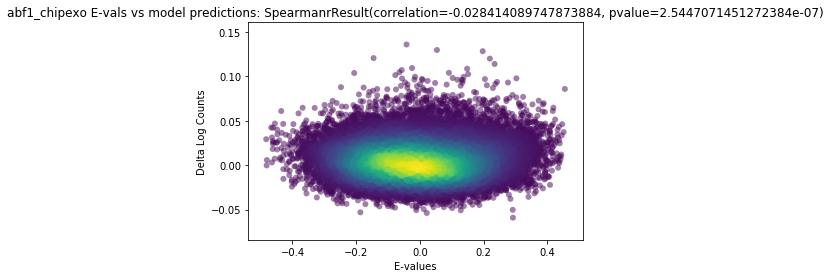

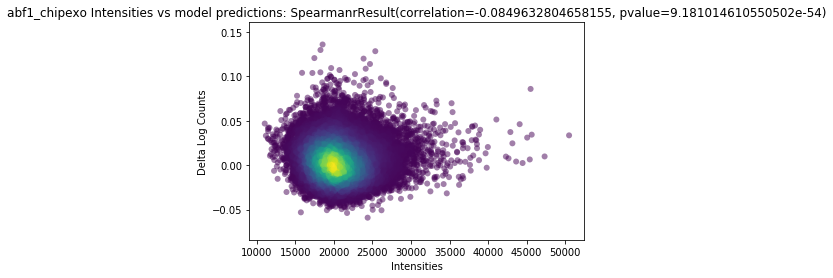

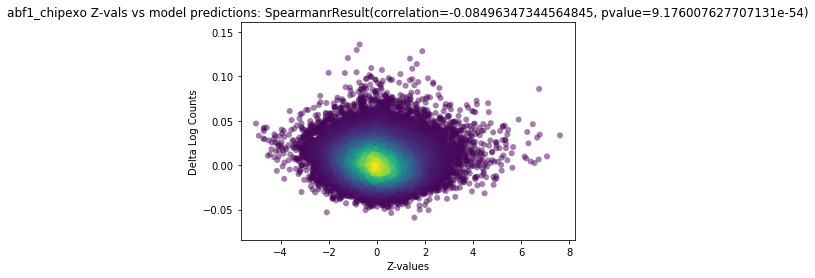

In [8]:
for key in keyToFiles:
    print(key)
    num_samples = min(len(keyToPeaks[key]), 100)
    val0, val1 = keyToFiles[key]
    with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL,'RevCompConv1D': RevCompConv1D}):
        model = load_model(val0)
    yvals = []
    seqToDeltaLogCount = {}
    for seq_index, curr_seq in enumerate(seqs):
        if seq_index%1000 == 0: print("processed ", seq_index, " seqs")
        pre_seqs = []
        post_seqs = []
        indices = np.random.choice(len(keyToPeaks[key]), num_samples, replace=False)
        for idx in indices:
            pre_seq = dinuc_shuffle(keyToPeaks[key][idx])
            post_seq = fill_into_center(pre_seq, curr_seq)
            pre_seqs.append(pre_seq)
            post_seqs.append(post_seq)
        pre = model.predict([getOneHot(pre_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
        post = model.predict([getOneHot(post_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
        seqToDeltaLogCount[curr_seq] = np.mean(post[0]-pre[0])
        yvals.append(seqToDeltaLogCount[curr_seq])

    K.clear_session()
    del model

#     json.dump(seqToDeltaLogCount,
#           codecs.open("data/preds/"+key+".json", 'w', encoding='utf-8'),
#           separators=(',', ':'),
#           sort_keys=True, indent=4)

    xy = np.vstack([evals,yvals])
    z = gaussian_kde(xy)(xy)
    smallFont = {'size' : 10}
    plt.rc('font', **smallFont)
    fig, ax = plt.subplots()
    ax.scatter(evals, yvals, c=z, edgecolor='', alpha=0.5)
    plt.xlabel("E-values")
    plt.ylabel("Delta Log Counts")
    plt.title(key+" E-vals vs model predictions: "+str(spearmanr(evals, yvals)))
    plt.show()

    xy = np.vstack([values,yvals])
    z = gaussian_kde(xy)(xy)
    smallFont = {'size' : 10}
    plt.rc('font', **smallFont)
    fig, ax = plt.subplots()
    ax.scatter(values, yvals, c=z, edgecolor='', alpha=0.5)
    plt.xlabel("Intensities")
    plt.ylabel("Delta Log Counts")
    plt.title(key+" Intensities vs model predictions: "+str(spearmanr(values, yvals)))
    plt.show()

    xy = np.vstack([zvals,yvals])
    z = gaussian_kde(xy)(xy)
    smallFont = {'size' : 10}
    plt.rc('font', **smallFont)
    fig, ax = plt.subplots()
    ax.scatter(zvals, yvals, c=z, edgecolor='', alpha=0.5)
    plt.xlabel("Z-values")
    plt.ylabel("Delta Log Counts")
    plt.title(key+" Z-vals vs model predictions: "+str(spearmanr(zvals, yvals)))
    plt.show()

In [9]:
new_yvals = []
new_evals = []
new_values = []
new_zvals = []
for curr_seq in seqToEScores.keys():
    if seqToDeltaLogCount[curr_seq] <= 0.025 or seqToZScores[curr_seq] < 0.5:
        continue
    new_yvals.append(seqToDeltaLogCount[curr_seq])
    new_evals.append(seqToEScores[curr_seq])
    new_values.append(seqToValues[curr_seq])
    new_zvals.append(seqToZScores[curr_seq])

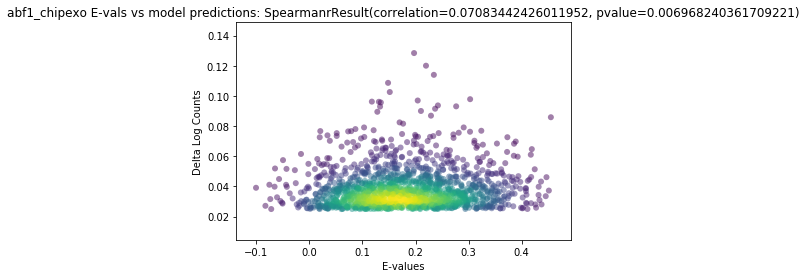

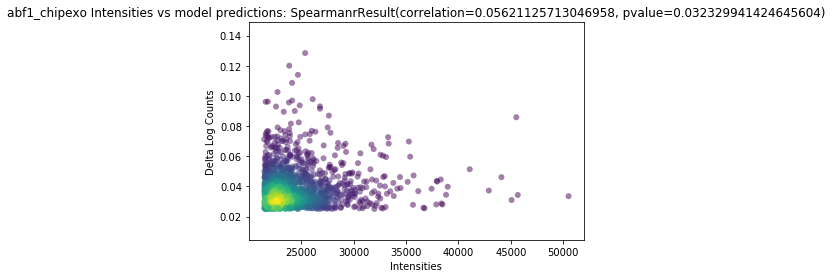

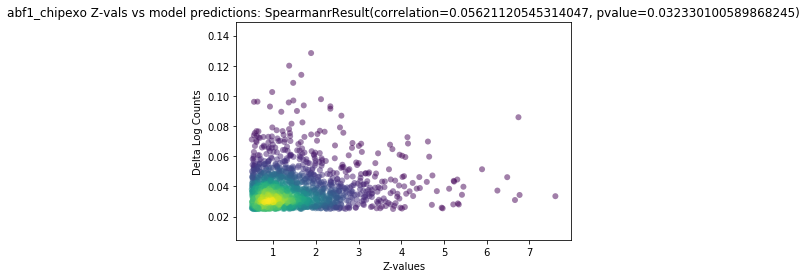

In [10]:
xy = np.vstack([new_evals,new_yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(new_evals, new_yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("E-values")
plt.ylabel("Delta Log Counts")
plt.title(key+" E-vals vs model predictions: "+str(spearmanr(new_evals, new_yvals)))
plt.show()

xy = np.vstack([new_values,new_yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(new_values, new_yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("Intensities")
plt.ylabel("Delta Log Counts")
plt.title(key+" Intensities vs model predictions: "+str(spearmanr(new_values, new_yvals)))
plt.show()

xy = np.vstack([new_zvals,new_yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(new_zvals, new_yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("Z-values")
plt.ylabel("Delta Log Counts")
plt.title(key+" Z-vals vs model predictions: "+str(spearmanr(new_zvals, new_yvals)))
plt.show()